In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_celeba_config.json")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
logger = config.get_logger('valid')

In [6]:
trainer.fit(model, data, ckpt_path="saved/models/CelebA_Ppc/0518_035349/checkpoint_4499.ckpt")

Missing logger folder: saved/log/CelebA_Ppc/0518_203401/lightning_logs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0518_203401 exists and is not empty.
Restoring states from the checkpoint path at saved/models/CelebA_Ppc/0518_035349/checkpoint_4499.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0518_035349' to '/workspace/shai_hulud/ppc_experiments/saved/models/CelebA_Ppc/0518_203401', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type       | Params
------------------------------------------
0 | graph      | CelebAPpc  | 390 K 
1 | predictive | Predictive | 0     
--------------------------------

Sanity Checking: |                                                                                            …

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
`Trainer.fit` stopped: `max_epochs=4500` reached.


In [7]:
model.graph.clear()
model.eval()
model.cuda()

LightningPpc(
  (graph): CelebAPpc(
    (prior): GaussianPrior()
    (likelihood): ConvolutionalDecoder(
      (linear): Sequential(
        (0): Linear(in_features=40, out_features=256, bias=True)
        (1): SiLU()
      )
      (convs): Sequential(
        (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
        (1): SiLU()
        (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): SiLU()
        (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): SiLU()
        (6): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): SiLU()
        (8): ConvTranspose2d(32, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (9): Identity()
        (10): Identity()
      )
    )
  )
  (predictive): Predictive()
)

In [34]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)
model._load_particles(indices, False)

In [42]:
with model.graph.condition(X=xs) as predictive:
    for i in range(299):
        _, log_weight = predictive(B=len(xs), lr=1e-5, P=model.num_particles)
        logger.info("Free energy at evaluation %d: %f" % (i+1, -log_weight.mean()))
    trace, _ = predictive(B=len(xs), lr=1e-5, P=model.num_particles)
logger.info("Free energy at evaluation 300: %f" % -log_weight.mean())
x_hats = trace.nodes['X']['fn'].base_dist.loc.mean(dim=0)

Free energy at evaluation 1: 4483.460449
Free energy at evaluation 2: 3592.071289
Free energy at evaluation 3: 2984.603516
Free energy at evaluation 4: 2494.942627
Free energy at evaluation 5: 2086.889893
Free energy at evaluation 6: 1738.441895
Free energy at evaluation 7: 1439.185425
Free energy at evaluation 8: 1173.198853
Free energy at evaluation 9: 940.059082
Free energy at evaluation 10: 730.672485
Free energy at evaluation 11: 546.808350
Free energy at evaluation 12: 380.325989
Free energy at evaluation 13: 229.277939
Free energy at evaluation 14: 89.203613
Free energy at evaluation 15: -35.557205
Free energy at evaluation 16: -152.403976
Free energy at evaluation 17: -255.090561
Free energy at evaluation 18: -352.006531
Free energy at evaluation 19: -440.198059
Free energy at evaluation 20: -521.325317
Free energy at evaluation 21: -597.893860
Free energy at evaluation 22: -669.704834
Free energy at evaluation 23: -736.009277
Free energy at evaluation 24: -799.651733
Free ener

In [10]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


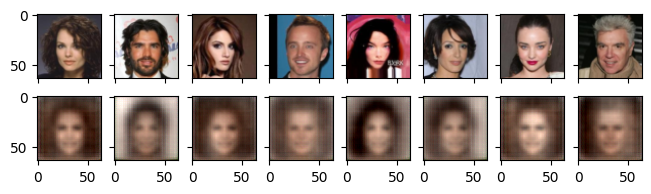

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=8, sharex="all", sharey="all", layout="compressed")

for i in range(8):
    orgs = xs[i].squeeze().detach().transpose(0, -1).cpu()
    estimates = x_hats[i].squeeze().detach().transpose(0, -1).cpu()
    axes[0, i].imshow(orgs)
    axes[1, i].imshow(estimates)

fig.savefig("ppc_celeba_recons.pdf", bbox_inches="tight")
plt.show()

In [12]:
del xs
del x_hats

In [13]:
model.graph.clear()

In [14]:
model.graph(B=8, lr=1e-5, mode="prior", P=model.num_particles)
for _ in range(299):
    model.graph(B=8, lr=1e-5, mode="prior", P=model.num_particles)
x_hats = model.graph(B=8, lr=1e-5, mode="prior", P=model.num_particles)
x_hats = x_hats.mean(dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


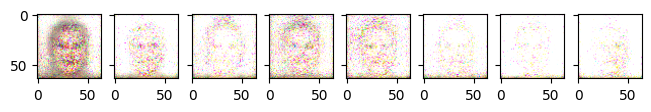

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=8, sharex="all", sharey="all", layout="compressed")

for i in range(8):
    estimates = x_hats[i].squeeze().detach().transpose(0, -1).cpu()
    axes[i].imshow(estimates)

fig.savefig("ppc_celeba_samples.pdf", bbox_inches="tight")
plt.show()

In [16]:
del x_hats
del trace

In [17]:
SEEDS = [123, 456, 789, 101112, 131415]

In [18]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), requires_grad=False)

In [19]:
with torch.no_grad():
    for (s, SEED) in enumerate(SEEDS):
        torch.manual_seed(SEED)
        np.random.seed(SEED)
        for b, (xs, target, indices) in enumerate(data.val_dataloader()):
            xs = xs.to(model.device)
            model._load_particles(indices, False)

            with model.graph.condition(X=xs) as predictive:
                trace, _ = model.graph(B=len(xs), lr=1e-5, P=model.num_particles)
            x_hats = trace.nodes['X']['value'].mean(dim=0)
            LOG_LIKELIHOODS[s] += trace.nodes['X']['fn'].log_prob(xs).sum().cpu()
            MEAN_SQUARED_ERROR[s] += ((xs - x_hats) ** 2).sum(dim=0).mean().cpu()
    
            del xs
            del x_hats
            del trace
            del target
            del indices
            logger.info("Evaluated likelihood for valid batch %d under seed %s" % (b, s))
    
        LOG_LIKELIHOODS[s] /= len(data.val_dataloader().dataset)
        MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().dataset)

Evaluated likelihood for valid batch 0 under seed 0
Evaluated likelihood for valid batch 1 under seed 0
Evaluated likelihood for valid batch 2 under seed 0
Evaluated likelihood for valid batch 3 under seed 0
Evaluated likelihood for valid batch 4 under seed 0
Evaluated likelihood for valid batch 5 under seed 0
Evaluated likelihood for valid batch 6 under seed 0
Evaluated likelihood for valid batch 7 under seed 0
Evaluated likelihood for valid batch 8 under seed 0
Evaluated likelihood for valid batch 9 under seed 0
Evaluated likelihood for valid batch 10 under seed 0
Evaluated likelihood for valid batch 11 under seed 0
Evaluated likelihood for valid batch 12 under seed 0
Evaluated likelihood for valid batch 13 under seed 0
Evaluated likelihood for valid batch 14 under seed 0
Evaluated likelihood for valid batch 15 under seed 0
Evaluated likelihood for valid batch 16 under seed 0
Evaluated likelihood for valid batch 17 under seed 0
Evaluated likelihood for valid batch 18 under seed 0
Eva

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluated likelihood for valid batch 0 under seed 1
Evaluated likelihood for valid batch 1 under seed 1
Evaluated likelihood for valid batch 2 under seed 1
Evaluated likelihood for valid batch 3 under seed 1
Evaluated likelihood for valid batch 4 under seed 1
Evaluated likelihood for valid batch 5 under seed 1
Evaluated likelihood for valid batch 6 under seed 1
Evaluated likelihood for valid batch 7 under seed 1
Evaluated likelihood for valid batch 8 under seed 1
Evaluated likelihood for valid batch 9 under seed 1
Evaluated likelihood for valid batch 10 under seed 1
Evaluated likelihood for valid batch 11 under seed 1
Evaluated likelihood for valid batch 12 under seed 1
Evaluated likelihood for valid batch 13 under seed 1
Evaluated likelihood for valid batch 14 under seed 1
Evaluated likelihood for valid batch 15 under seed 1
Evaluated likelihood for valid batch 16 under seed 1
Evaluated likelihood for valid batch 17 under seed 1
Evaluated likelihood for valid batch 18 under seed 1
Eva

In [20]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-30444.9004), tensor(19.3083))

In [21]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(0.0733), tensor(0.))

In [22]:
model.graph.clear()

In [23]:
NUM_SAMPLES = 50e3
num_samples = 0

In [24]:
import utils.util as util

In [25]:
util.ensure_dir('data/celeba_ppc')

KeyboardInterrupt: 

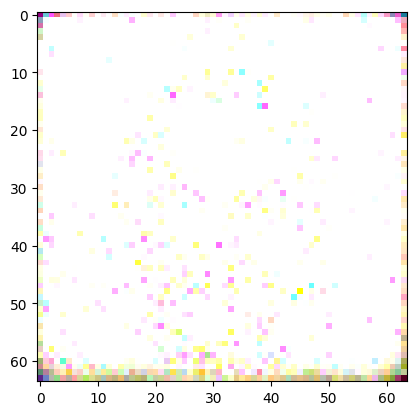

In [26]:
plt.set_loglevel("error")

while num_samples < NUM_SAMPLES:
    x_hats = model.graph(B=data.batch_size, mode="prior", P=model.num_particles).mean(dim=0)
    for k in range(data.batch_size):
        fig = plt.imshow(x_hats[k].squeeze().detach().transpose(0, -1).cpu())
        plt.savefig("data/celeba_ppc/%d.jpg" % (num_samples + k))
    num_samples += data.batch_size

    logger.info("Generated %d sample images" % num_samples)